<a href="https://colab.research.google.com/github/heyitseufra/heyitseufra-ProjectAkhirDeepLearning/blob/main/Brigitta's_Team_Project_Akhir_Deep_Learning_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TRANSFORMATION OF TABULAR DATA INTO 2D REPRESENTATIONS FOR ATTACK DETECTION USING CNN ON THE HIKARI-2021 DATASET**

Nama Anggota Kelompok:
1. Asti Syafitri (225150201111006)
2. Brigitta Mery Rosarie Eufra Nilapaksi (225150207111016)
3. Paula Sugiarto (225150207111058)

#**1. Mengunduh Dataset**

In [ ]:
# Mengunduh dataset terbaru dari Kaggle menggunakan kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kk0105/allflowmeter-hikari2021")

# Menampilkan path folder dataset yang telah diunduh
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/kk0105/allflowmeter-hikari2021/versions/1


#**2. Memuat dan Memeriksa Data**

In [ ]:
# Mengimpor pustaka yang diperlukan
import os
import pandas as pd

# Path folder dataset
dataset_path = '/root/.cache/kagglehub/datasets/kk0105/allflowmeter-hikari2021/versions/1'
files = os.listdir(dataset_path)

print("File yang ada di dalam folder dataset:")
print(files)

# Membaca file CSV
csv_file_path = os.path.join(dataset_path, 'ALLFLOWMETER_HIKARI2021.csv')
data = pd.read_csv(csv_file_path)

# Menampilkan kolom dan sampel data
print("Kolom dalam dataset:", data.columns.tolist())
print(data.head())

# Menampilkan header dan tipe datanya
for column, value in data.iloc[0].items():
    print(f"{column} : {type(value)}")

File yang ada di dalam folder dataset:
['ALLFLOWMETER_HIKARI2021.csv']
Kolom dalam dataset: ['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp', 'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot', 'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot', 'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count', 'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count', 'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count', 'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std', 'flow_pkts_payload.min', 'flow_pkts_payload.max', 'fl

#**3. Preprocessing Data**

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Hapus kolom tidak relevan
data = data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'uid', 'originh', 'responh'], errors='ignore')

# Label Encoding untuk kolom target
label_encoder = LabelEncoder()
data['traffic_category'] = label_encoder.fit_transform(data['traffic_category'])

# Normalisasi kolom numerik
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Pisahkan fitur (X) dan label (y)
X = data.drop(columns=['traffic_category'])
y = data['traffic_category'].values
X_np = X.values  # Konversi X ke NumPy array


#**4. Diskretisasi Label untuk SMOTE**

In [ ]:
n_bins = 5  # Tentukan jumlah kategori
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
y_labels_discretized = discretizer.fit_transform(y.reshape(-1, 1)).astype(int).ravel()

# 3. Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_np, y_labels_discretized)

# Format ulang data untuk input CNN
X_resampled = X_resampled.reshape((X_resampled.shape[0], X.shape[1], 1, 1))
y_resampled = to_categorical(y_resampled)

# 4. Membagi Data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


#**5. Membagi Data**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

#**6. Membangun Model CNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),
    Conv2D(32, (3, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Conv2D(64, (3, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_resampled.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#**7. Melatih Model**

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 222s 13ms/step - accuracy: 0.9035 - loss: 0.1918 - val_accuracy: 0.9182 - val_loss: 0.1665
Epoch 2/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 260s 13ms/step - accuracy: 0.9144 - loss: 0.1717 - val_accuracy: 0.9213 - val_loss: 0.1619
Epoch 3/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 261s 13ms/step - accuracy: 0.9181 - loss: 0.1667 - val_accuracy: 0.9238 - val_loss: 0.1597
Epoch 4/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 265s 13ms/step - accuracy: 0.9215 - loss: 0.1622 - val_accuracy: 0.9264 - val_loss: 0.1579
Epoch 5/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 270s 13ms/step - accuracy: 0.9231 - loss: 0.1599 - val_accuracy: 0.9257 - val_loss: 0.1549
Epoch 6/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 233s 13ms/step - accuracy: 0.9248 - loss: 0.1574 - val_accuracy: 0.9265 - val_loss: 0.1545
Epoch 7/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 280s 14ms/step - accuracy: 0.9247 - loss: 0.1574 - val_accuracy: 0.9286 - val_loss: 0.1515
Epoch 8/10
17372/17372 ━━━━━━━━━━━━━━━━━━━━ 237s 13ms/s

#**8. Evaluasi Model**

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

10858/10858 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9295 - loss: 0.1504
Test Loss: 0.15010015666484833, Test Accuracy: 0.9295889139175415


#**9. Metrik Tambahan**

10858/10858 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83     69323
           1       0.86      0.77      0.81     69211
           2       1.00      1.00      1.00     69760
           3       1.00      1.00      1.00     69604
           4       1.00      1.00      1.00     69533

    accuracy                           0.93    347431
   macro avg       0.93      0.93      0.93    347431
weighted avg       0.93      0.93      0.93    347431



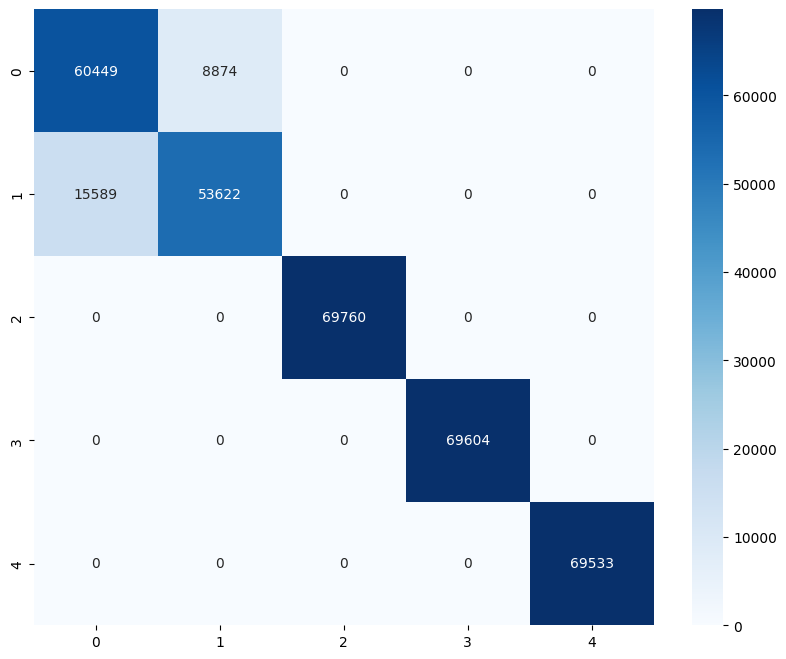

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.show()